In [2]:
# import libraries

# For plotting
"seaborn: statistical data visualization"
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("white")
%matplotlib inline
#for matrix math
import numpy as np
#for normalization + probability density function computation
from scipy import stats
#for data preprocessing
import pandas as pd
from math import sqrt, log, exp, pi
from random import uniform
print("import done")


import done


[-0.87012123  8.72030264  3.37633571 ...  9.06582318  6.66174451
  7.73636841]


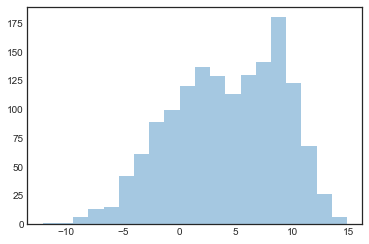

In [3]:
Mean1 = 2  # Input parameter, mean of first normal probability distribution
Standard_dev1 = 4 #@param {type:"number"}
Mean2 = 9 # Input parameter, mean of second normal  probability distribution
Standard_dev2 = 2 #@param {type:"number"}

# generate data
y1 = np.random.normal(Mean1, Standard_dev1, 1000)
y2 = np.random.normal(Mean2, Standard_dev2, 500)
data=np.append(y1,y2)
print(data)

# For data visiualisation calculate left and right of the graph
Min_graph = min(data)
Max_graph = max(data)
x = np.linspace(Min_graph, Max_graph, 2000) # to plot the data

sns.distplot(data, bins=20, kde=False)

In [4]:
class Gaussian:
    "Model univariate Gaussian"
    def __init__(self, mu, sigma):
        #mean and standard deviation
        self.mu = mu
        self.sigma = sigma

    #probability density function
    def pdf(self, datum):
        "PDF Of gaussian distribution"
        "Probability of a data point given the current parameters"
        u = (datum - self.mu) / abs(self.sigma)
        y = (1 / (sqrt(2 * pi) * abs(self.sigma))) * exp(-u * u / 2)
        return y
    
    def __repr__(self):
        return 'Gaussian({0:4.6}, {1:4.6})'.format(self.mu, self.sigma)
print("done")

done


Best single Gaussian: μ = 4.2, σ = 4.9
Mean of fitting gaussian is 4.2146301403131705
Standard deviation of fitting gaussian is 4.850670553053463


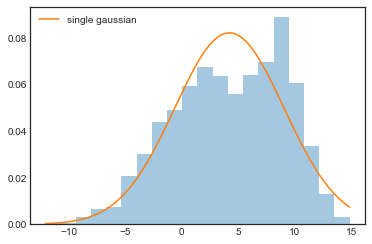

In [9]:
"A single Gaussion will not fit the data well"

#gaussian of best fit
best_single = Gaussian(np.mean(data), np.std(data))
print('Best single Gaussian: μ = {:.2}, σ = {:.2}'.format(best_single.mu, best_single.sigma))


#fit a single gaussian curve to the data
print('Mean of fitting gaussian is '+ str(best_single.mu))
print('Standard deviation of fitting gaussian is '+ str(best_single.sigma))
g_single = stats.norm(best_single.mu, best_single.sigma).pdf(x)
sns.distplot(data, bins=20, kde=False, norm_hist=True)
plt.plot(x, g_single, label='single gaussian')
plt.legend();

In [19]:
class GaussianMixture_self:
    "Model mixture of two univariate Gaussians and their EM estimation"

    def __init__(self, data, mu_min=min(data), mu_max=max(data), sigma_min=1, sigma_max=1, mix=.5):
        self.data = data
        #todo the Algorithm would be numerical enhanced by normalizing the data first, next do all the EM steps and do the de-normalising at the end
        #init with multiple gaussians
        
        #'Uniform' draws samples from a uniform distribution.


        self.one = Gaussian(uniform(mu_min, mu_max), 
                            uniform(sigma_min, sigma_max))
        self.two = Gaussian(uniform(mu_min, mu_max), 
                            uniform(sigma_min, sigma_max))
        
        #how well to mix the gaussians
        self.mix = mix

    def Estep(self):
        "E(stimation)-step, assign each point to gaussian 1 or 2 with a percentage"
        
        # compute weights
        self.loglike = 0. # = log(p = 1)
        for datum in self.data:  
            # unnormalized weights
            wp1 = self.one.pdf(datum) * self.mix
            wp2 = self.two.pdf(datum) * (1. - self.mix)
            # compute denominator
            den = wp1 + wp2
            # normalize
            wp1 /= den   
            wp2 /= den     # wp1+wp2= 1, it either belongs to gaussian 1 or gaussion 2
            # add into loglike
            self.loglike += log(wp1 + wp2) #freshening up self.loglike in the process
            # yield weight tuple
            yield (wp1, wp2)

    def Mstep(self, weights):
        "Perform an M(aximization)-step"
        # compute denominators
        (left, rigt) = zip(*weights) 
        one_den = sum(left)
        two_den = sum(rigt)

        # compute new means
        self.one.mu = sum(w * d  for (w, d) in zip(left, data)) / one_den
        self.two.mu = sum(w * d  for (w, d) in zip(rigt, data)) / two_den
        
        # compute new sigmas
        self.one.sigma = sqrt(sum(w * ((d - self.one.mu) ** 2)
                                  for (w, d) in zip(left, data)) / one_den)
        self.two.sigma = sqrt(sum(w * ((d - self.two.mu) ** 2)
                                  for (w, d) in zip(rigt, data)) / two_den)
        # compute new mix
        self.mix = one_den / len(data)

     
    "Verbose is a general programming term for produce lots of logging output. You can think of it as asking the program to tell me everything about what you are doing all the time."
    
    def iterate(self, N=1, verbose=False):
        "Perform N iterations, then compute log-likelihood"
        for i in range(1, N+1):
            self.Mstep(self.Estep()) #The heart of the algorith, perform E-stepand next M-step
            if verbose:
                print('{0:2} {1}'.format(i, self))
        self.Estep() # to freshen up self.loglike

    def pdf(self, x):
        return (self.mix)*self.one.pdf(x) + (1-self.mix)*self.two.pdf(x)
        
    def __repr__(self):
        return 'GaussianMixture({0}, {1}, mix={2.03})'.format(self.one, 
                                                              self.two, 
                                                              self.mix)

    def __str__(self):
        return 'Mixture: {0}, {1}, mix={2:.03})'.format(self.one, 
                                                        self.two, 
                                                        self.mix)
print("done")

done


In [20]:
# See the algorithem in action
n_iterations = 5
best_mix = None
best_loglike = float('-inf')
mix = GaussianMixture_self(data)
for _ in range(n_iterations):
    try:
        #train!
        mix.iterate(verbose=True)
        if mix.loglike > best_loglike:
            best_loglike = mix.loglike
            best_mix = mix
        
    except (ZeroDivisionError, ValueError, RuntimeWarning): # Catch division errors from bad starts, and just throw them out...
        print("one less")
        pass

 1 Mixture: Gaussian(-8.99228, 1.37431), Gaussian(4.28471, 4.76586), mix=0.00528)
 1 Mixture: Gaussian(-8.33561, 1.46212), Gaussian(4.25674, 4.80318), mix=0.00334)
 1 Mixture: Gaussian(-7.82462, 1.38221), Gaussian(4.24806, 4.81513), mix=0.00277)
 1 Mixture: Gaussian(-7.47141, 1.24351), Gaussian(4.24516, 4.81962), mix=0.00261)
 1 Mixture: Gaussian(-7.26184, 1.12581), Gaussian(4.24498, 4.82065), mix=0.00264)


Computing best model with random restarts...

Best Gaussian Mixture : μ = 1.8, σ = 4.1 with μ = 8.9, σ = 2.0


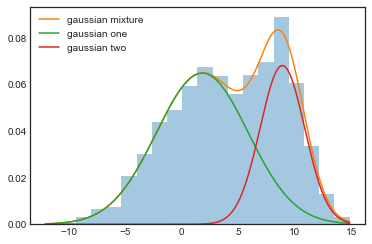

In [21]:
# Find best Mixture Gaussian model
n_iterations = 300
n_random_restarts = 4
best_mix = None
best_loglike = float('-inf')
print('Computing best model with random restarts...\n')
for _ in range(n_random_restarts):
    mix = GaussianMixture_self(data)
    for _ in range(n_iterations):
        try:
            mix.iterate()
            if mix.loglike > best_loglike:
                best_loglike = mix.loglike
                best_mix = mix
        except (ZeroDivisionError, ValueError, RuntimeWarning): # Catch division errors from bad starts, and just throw them out...
            pass
print('Best Gaussian Mixture : μ = {:.2}, σ = {:.2} with μ = {:.2}, σ = {:.2}'.format(best_mix.one.mu, best_mix.one.sigma, best_mix.two.mu, best_mix.two.sigma))

#Show mixture
sns.distplot(data, bins=20, kde=False, norm_hist=True)
g_both = [best_mix.pdf(e) for e in x]
plt.plot(x, g_both, label='gaussian mixture');
g_left = [best_mix.one.pdf(e) * best_mix.mix for e in x]
plt.plot(x, g_left, label='gaussian one');
g_right = [best_mix.two.pdf(e) * (1-best_mix.mix) for e in x]
plt.plot(x, g_right, label='gaussian two');
plt.legend();